In [39]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam,Adamax
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import binary_crossentropy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
import os
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

def F1_score(y_true, y_pred):
    # Clip y_true and y_pred between 0 and 1
    y_true = K.clip(y_true, min_value=0, max_value=1)
    y_pred = K.clip(y_pred, min_value=0, max_value=1)

    # Calculate true positives, etc. (without explicit casting)
    tp = K.sum(K.round(K.cast(y_true * y_pred, 'float32')))
    fp = K.sum(K.round(K.cast(K.clip(y_pred - y_true, 0, 1), 'float32')))
    fn = K.sum(K.round(K.cast(K.clip(y_true - y_pred, 0, 1), 'float32')))

    # Calculate precision and recall (using float32 for division)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate F1-score (using float32 for division)
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1_val

In [41]:
limiter = 1000
train_dir = '/home/rharikr3/training_test_split/train'
test_dir = '/home/rharikr3/training_test_split/val'
classes=sorted(os.listdir(train_dir))
print('there are ', len(classes), ' classes ', classes[0], ' and ', classes[1])
dir_list=[train_dir, test_dir]
names=['train', 'test']
zip_list=zip(names, dir_list)
for name, dir in zip_list:
    filepaths=[]
    labels=[]
    class_list=sorted(os.listdir(dir))
    for klass in class_list:
        classpath=os.path.join(dir, klass)
        flist=sorted(os.listdir(classpath))
        if name == 'train':
            flist=np.random.choice(flist, limiter, replace=True) # randomly select limiter number of files from train_dir for each class
        desc=f'{name}-{klass}'
        for f in tqdm(flist, ncols=100, colour='blue', unit='files', desc=desc):
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if name == 'train':
        train_df=pd.concat([Fseries, Lseries], axis=1)
        train_df, valid_df=train_test_split(train_df, test_size=.1, shuffle=True, random_state=123, stratify=train_df['labels'])
    else:  
        test_df=pd.concat([Fseries, Lseries], axis=1)
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 

there are  2  classes  FAKE  and  REAL


test-REAL: 100%|███████████████████████████████████████████| 217/217 [00:00<00:00, 815559.11files/s]

train_df length:  1800   test_df length:  706   valid_df length:  200


In [42]:
gen=ImageDataGenerator()
# I will be using an EfficientNet model which requires a minimum image size of 32 X 32
img_size=(64,64)
bs=32 # set the batch size
train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'binary', color_mode='rgb', shuffle=True, batch_size=bs)
valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'binary', color_mode='rgb', shuffle=False, batch_size=bs)
test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'binary', color_mode='rgb', shuffle=False, batch_size=bs)
labels=test_gen.labels

Found 1800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 706 validated image filenames belonging to 2 classes.


In [56]:
# Define paths to your new dataset


# Assuming the new dataset has the same structure as before (REAL and FAKE subfolders)
img_size = (64, 64)  # Set the image size


# Load your pretrained model
pretrained_model = tf.keras.models.load_model('/scratch/rharikr3/working/efficientLatest.h5', custom_objects={'f1_score': F1_score})


total_layers = len(pretrained_model.layers)
trainable_layers_count = int(total_layers * 0.7)

# Freeze layers up to trainable_layers_count   freezes the initial 70% of the layers
for layer in pretrained_model.layers[:trainable_layers_count]:
    layer.trainable = False

# Unfreeze layers after trainable_layers_count
for layer in pretrained_model.layers[trainable_layers_count:]:
    layer.trainable = True

'''
# Freeze layers in the pretrained model (optional)
for layer in pretrained_model.layers:
    layer.trainable = True
'''
# Add new output layer for the new classification task
x = pretrained_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(2, activation='sigmoid',name='output_layer')(x)  # Assuming 2 classes for REAL and FAKE images
model = Model(inputs=pretrained_model.input, outputs=output)

# Compile the model with appropriate optimizer and loss
model.compile(Adamax(learning_rate=.01), loss='sparse_categorical_crossentropy', metrics=['accuracy', F1_score])
#model.compile(Adamax(learning_rate=.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy', F1_score])


# Create data generators for the new dataset
# Train the model on the new dataset
history=model.fit(train_gen, epochs=20, validation_data=test_gen)

# Evaluate the model on the test set
model.evaluate(test_gen)

# Save the trained transfer-learned model for future use
model.save('/home/rharikr3/transferModel/Model.h5')

Epoch 1/20
57/57 [==============================] - 14s 172ms/step - loss: 1.0164 - accuracy: 0.7161 - F1_score: 0.4686 - val_loss: 0.9404 - val_accuracy: 0.7096 - val_F1_score: 0.2285
Epoch 2/20
57/57 [==============================] - 9s 155ms/step - loss: 0.7299 - accuracy: 0.8300 - F1_score: 0.4896 - val_loss: 0.4605 - val_accuracy: 0.9419 - val_F1_score: 0.2251
Epoch 3/20
57/57 [==============================] - 9s 157ms/step - loss: 0.6696 - accuracy: 0.8506 - F1_score: 0.4938 - val_loss: 0.4594 - val_accuracy: 0.9363 - val_F1_score: 0.2230
Epoch 4/20
57/57 [==============================] - 9s 156ms/step - loss: 0.5527 - accuracy: 0.8744 - F1_score: 0.4878 - val_loss: 0.4107 - val_accuracy: 0.9051 - val_F1_score: 0.2279
Epoch 5/20
57/57 [==============================] - 9s 156ms/step - loss: 0.5190 - accuracy: 0.8900 - F1_score: 0.4932 - val_loss: 0.3561 - val_accuracy: 0.9405 - val_F1_score: 0.2267
Epoch 6/20
57/57 [==============================] - 9s 156ms/step - loss: 0.465

In [51]:
def tr_plot(tr_data):
    start_epoch=0
    # Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)  # This is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    
    plt.style.use('fivethirtyeight')
    sc_label='Best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='Best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='Best epoch= '+ str(index_acc + 1+ start_epoch)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))
    
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss+1 +start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    
    axes[2].plot(Epochs, tf1, 'r', label='Training F1 score')    
    axes[2].plot(Epochs, vf1, 'g', label='Validation F1 score')
    index_tf1=np.argmax(tf1)  # This is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)  # This is the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch, vf1max, s=150, c='blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1 Score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout()    
    plt.show()
    return

In [52]:
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    test_count =len(preds)
    misclassified_classes=[]
    misclassified_files=[]
    misclassified_as = []
    pred_indices=[]
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]    
        if  pred_index != true_index:        
            errors +=1        
            misclassified_classes.append(classes[true_index])
            misclassified_as.append(classes[pred_index])
            file=test_gen.filenames[i]
            split=file.split('/')
            L=len(split)           
            f=split[L-2] +' '+ split[L-1]  
            misclassified_files.append(f)

    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels)
    ypred=np.array(pred_indices)
    f1score=F1_score(ytrue, ypred)* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg) 
    misclassified_classes=sorted(misclassified_classes)
    if len(misclassified_classes) > 0:
        misclassifications=[]
        for klass in misclassified_classes:
            mis_count=misclassified_classes.count(klass)
            misclassifications.append(mis_count)
        unique=len(np.unique(misclassified_classes)) 
        if unique==1:
            height=int(unique)
        else:
            height =int(unique/2)
        plt.figure(figsize=(10, height))
        plt.style.use('fivethirtyeight')
        plt.barh(misclassified_classes, misclassifications )
        plt.title( 'Classification Errors on Test Set by Class', fontsize=20, color='blue')
        plt.xlabel('NUMBER OF MISCLASSIFICATIONS', fontsize=20, color='blue')
        plt.ylabel('CLASS', fontsize=20, color='blue')
        plt.show()
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
        print("Classification Report:\n----------------------\n", clr)
    return f1score

In [ ]:
#20 epochs 70% frozen

23/23 [==============================] - 3s 84ms/step
There were 30 errors in 706 tests for an accuracy of  95.75 and an F1 score of  92.79


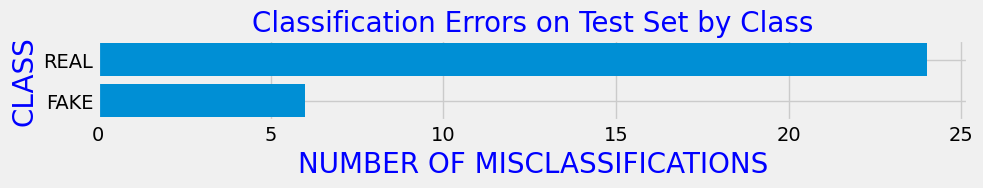

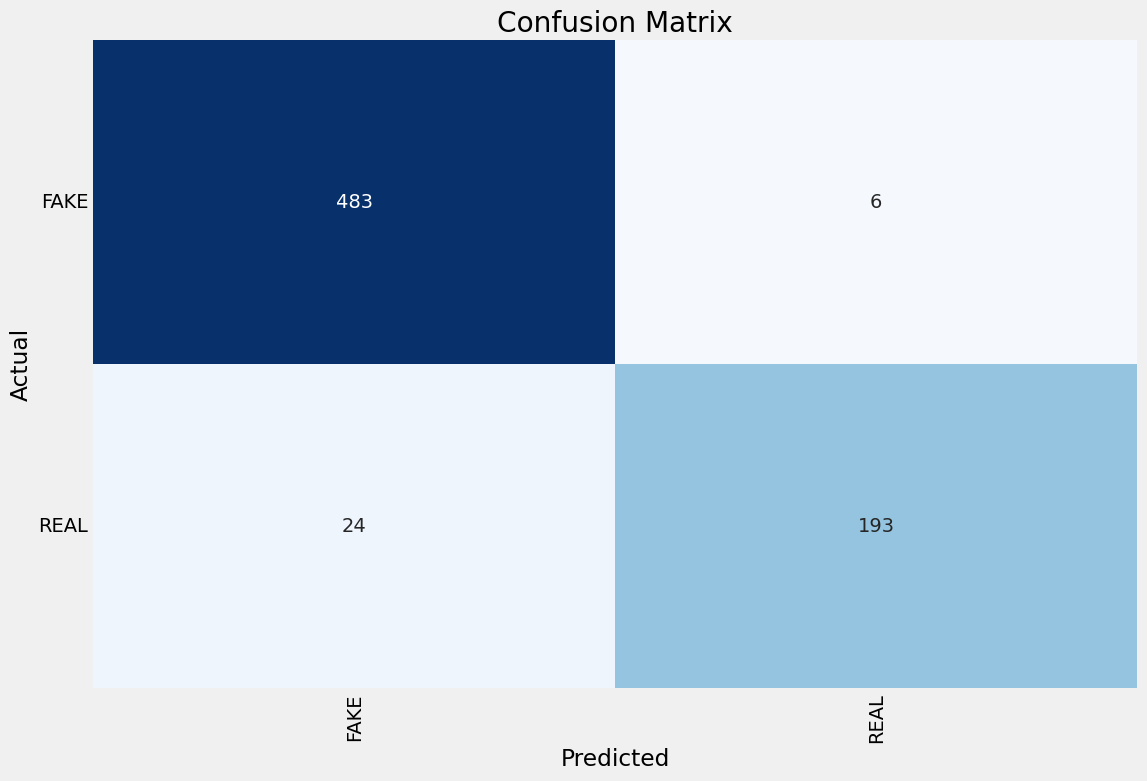

Classification Report:
----------------------
               precision    recall  f1-score   support

        FAKE     0.9527    0.9877    0.9699       489
        REAL     0.9698    0.8894    0.9279       217

    accuracy                         0.9575       706
   macro avg     0.9613    0.9386    0.9489       706
weighted avg     0.9579    0.9575    0.9570       706



In [57]:
f1score=predictor(model,test_gen)

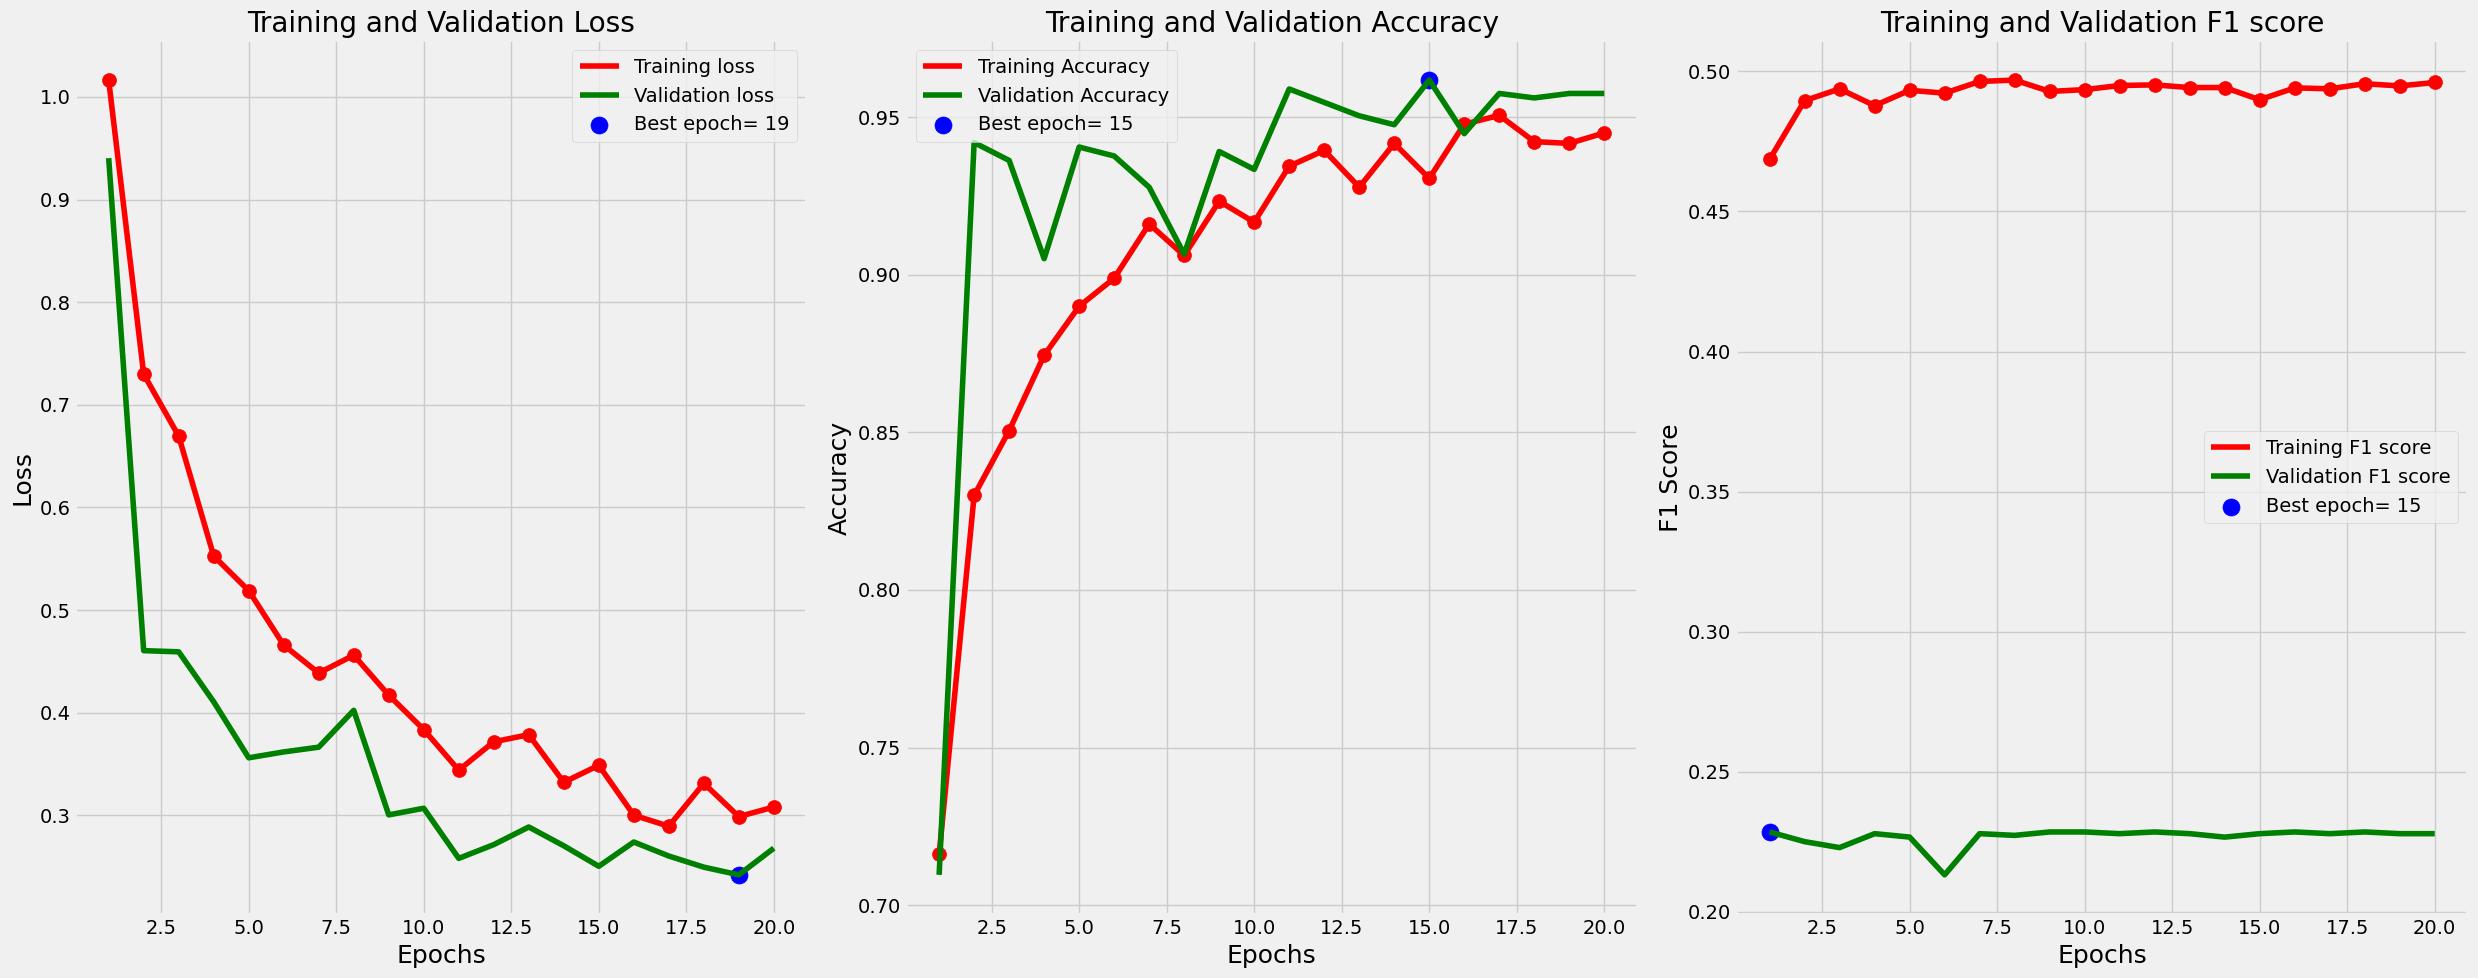

In [59]:
tr_plot(history)

23/23 [==============================] - 2s 85ms/step
There were 30 errors in 706 tests for an accuracy of  95.75 and an F1 score of  92.79


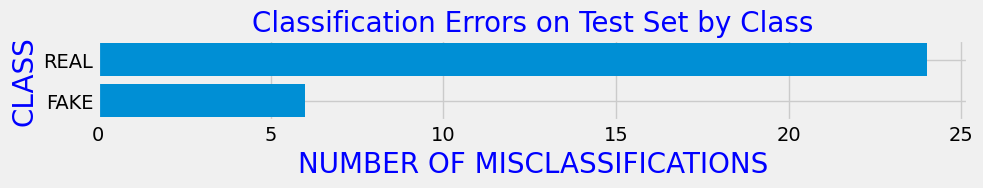

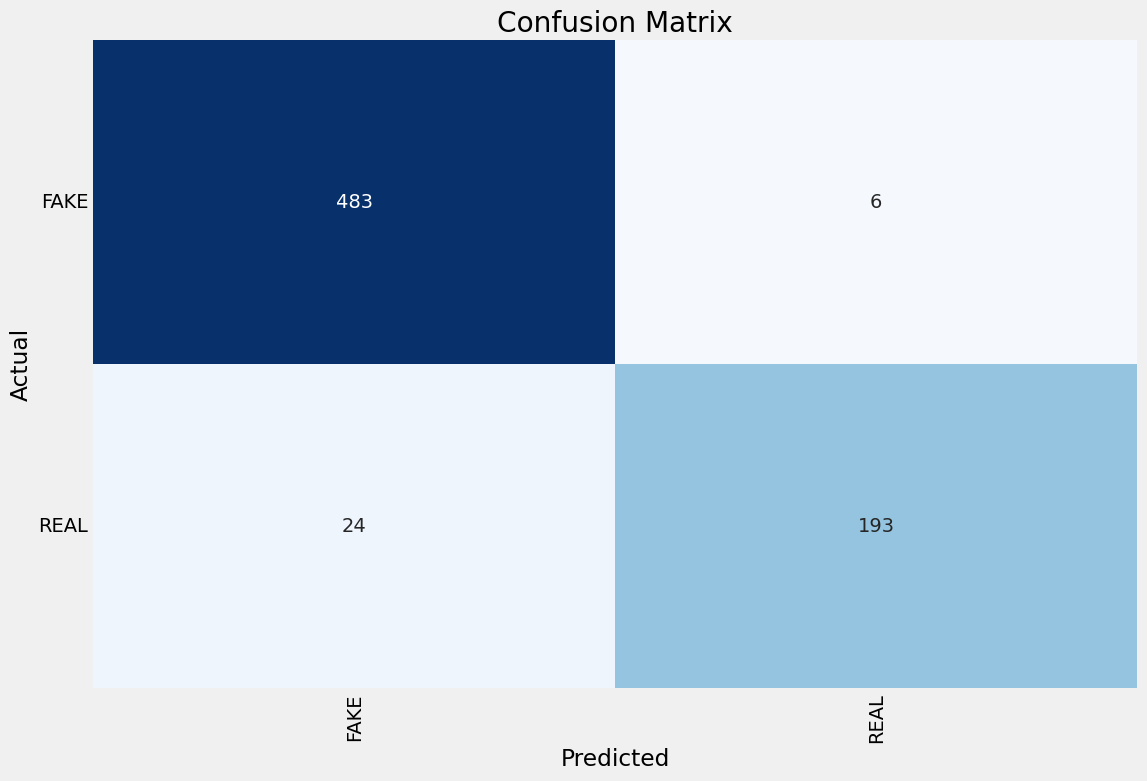

Classification Report:
----------------------
               precision    recall  f1-score   support

        FAKE     0.9527    0.9877    0.9699       489
        REAL     0.9698    0.8894    0.9279       217

    accuracy                         0.9575       706
   macro avg     0.9613    0.9386    0.9489       706
weighted avg     0.9579    0.9575    0.9570       706



In [58]:
f1score=predictor(model,test_gen)

In [ ]:
#10 epochs 70% frozen

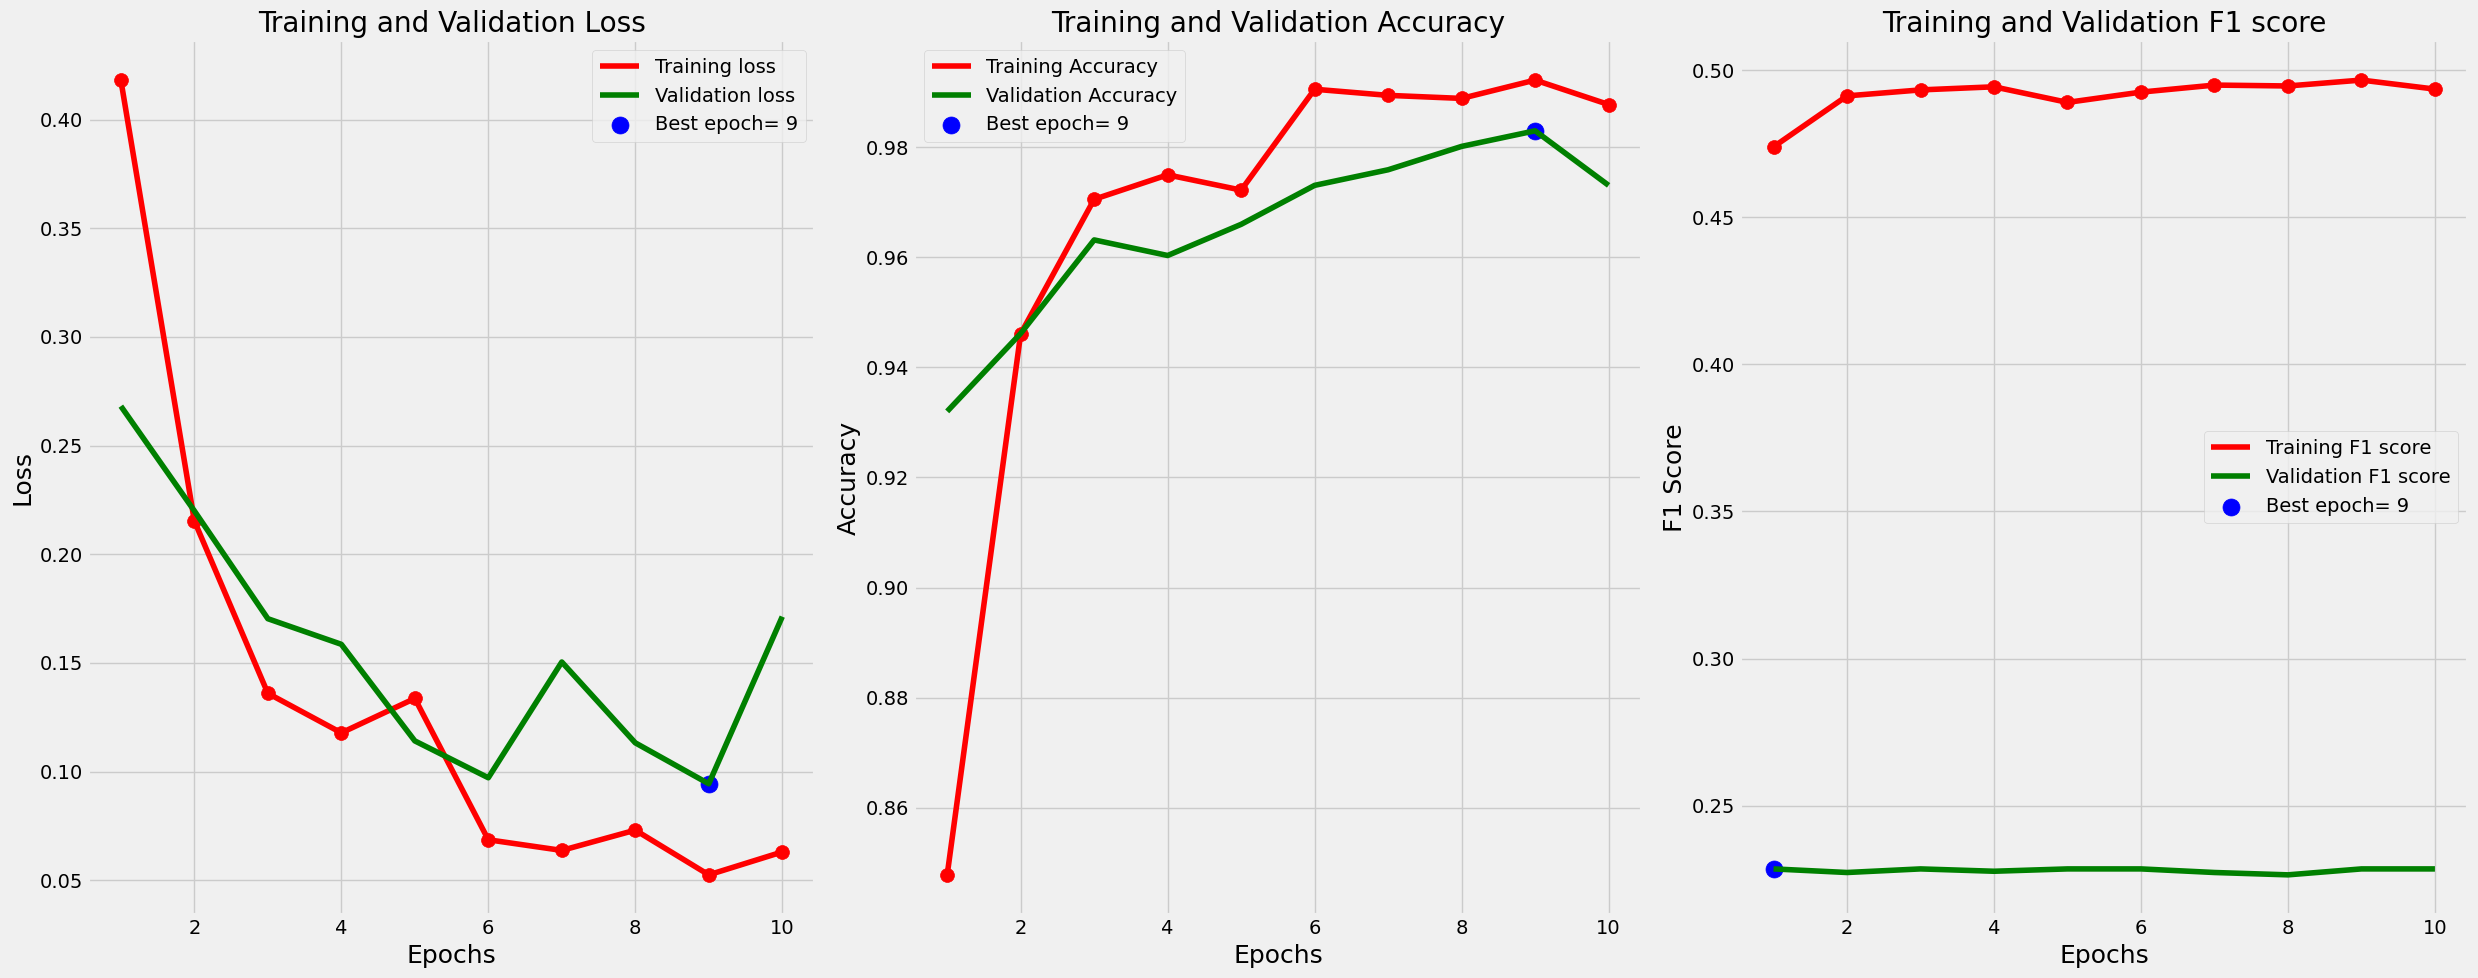

In [54]:
tr_plot(history)

In [ ]:
#20epochs fully unfrozen

23/23 [==============================] - 3s 86ms/step
There were 58 errors in 706 tests for an accuracy of  91.78 and an F1 score of  87.66


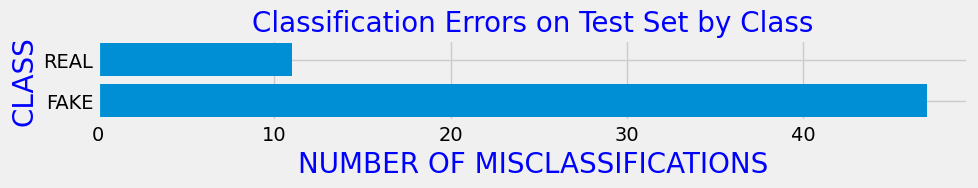

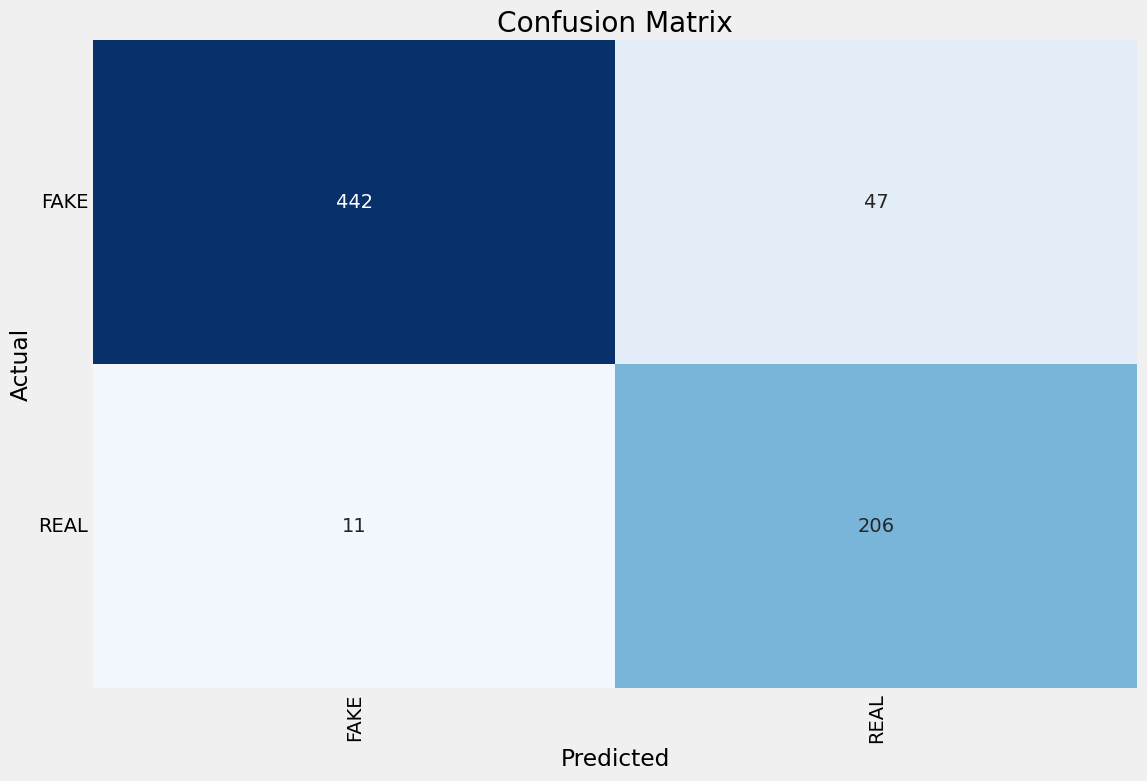

Classification Report:
----------------------
               precision    recall  f1-score   support

        FAKE     0.9757    0.9039    0.9384       489
        REAL     0.8142    0.9493    0.8766       217

    accuracy                         0.9178       706
   macro avg     0.8950    0.9266    0.9075       706
weighted avg     0.9261    0.9178    0.9194       706



In [46]:
f1score=predictor(model,test_gen)

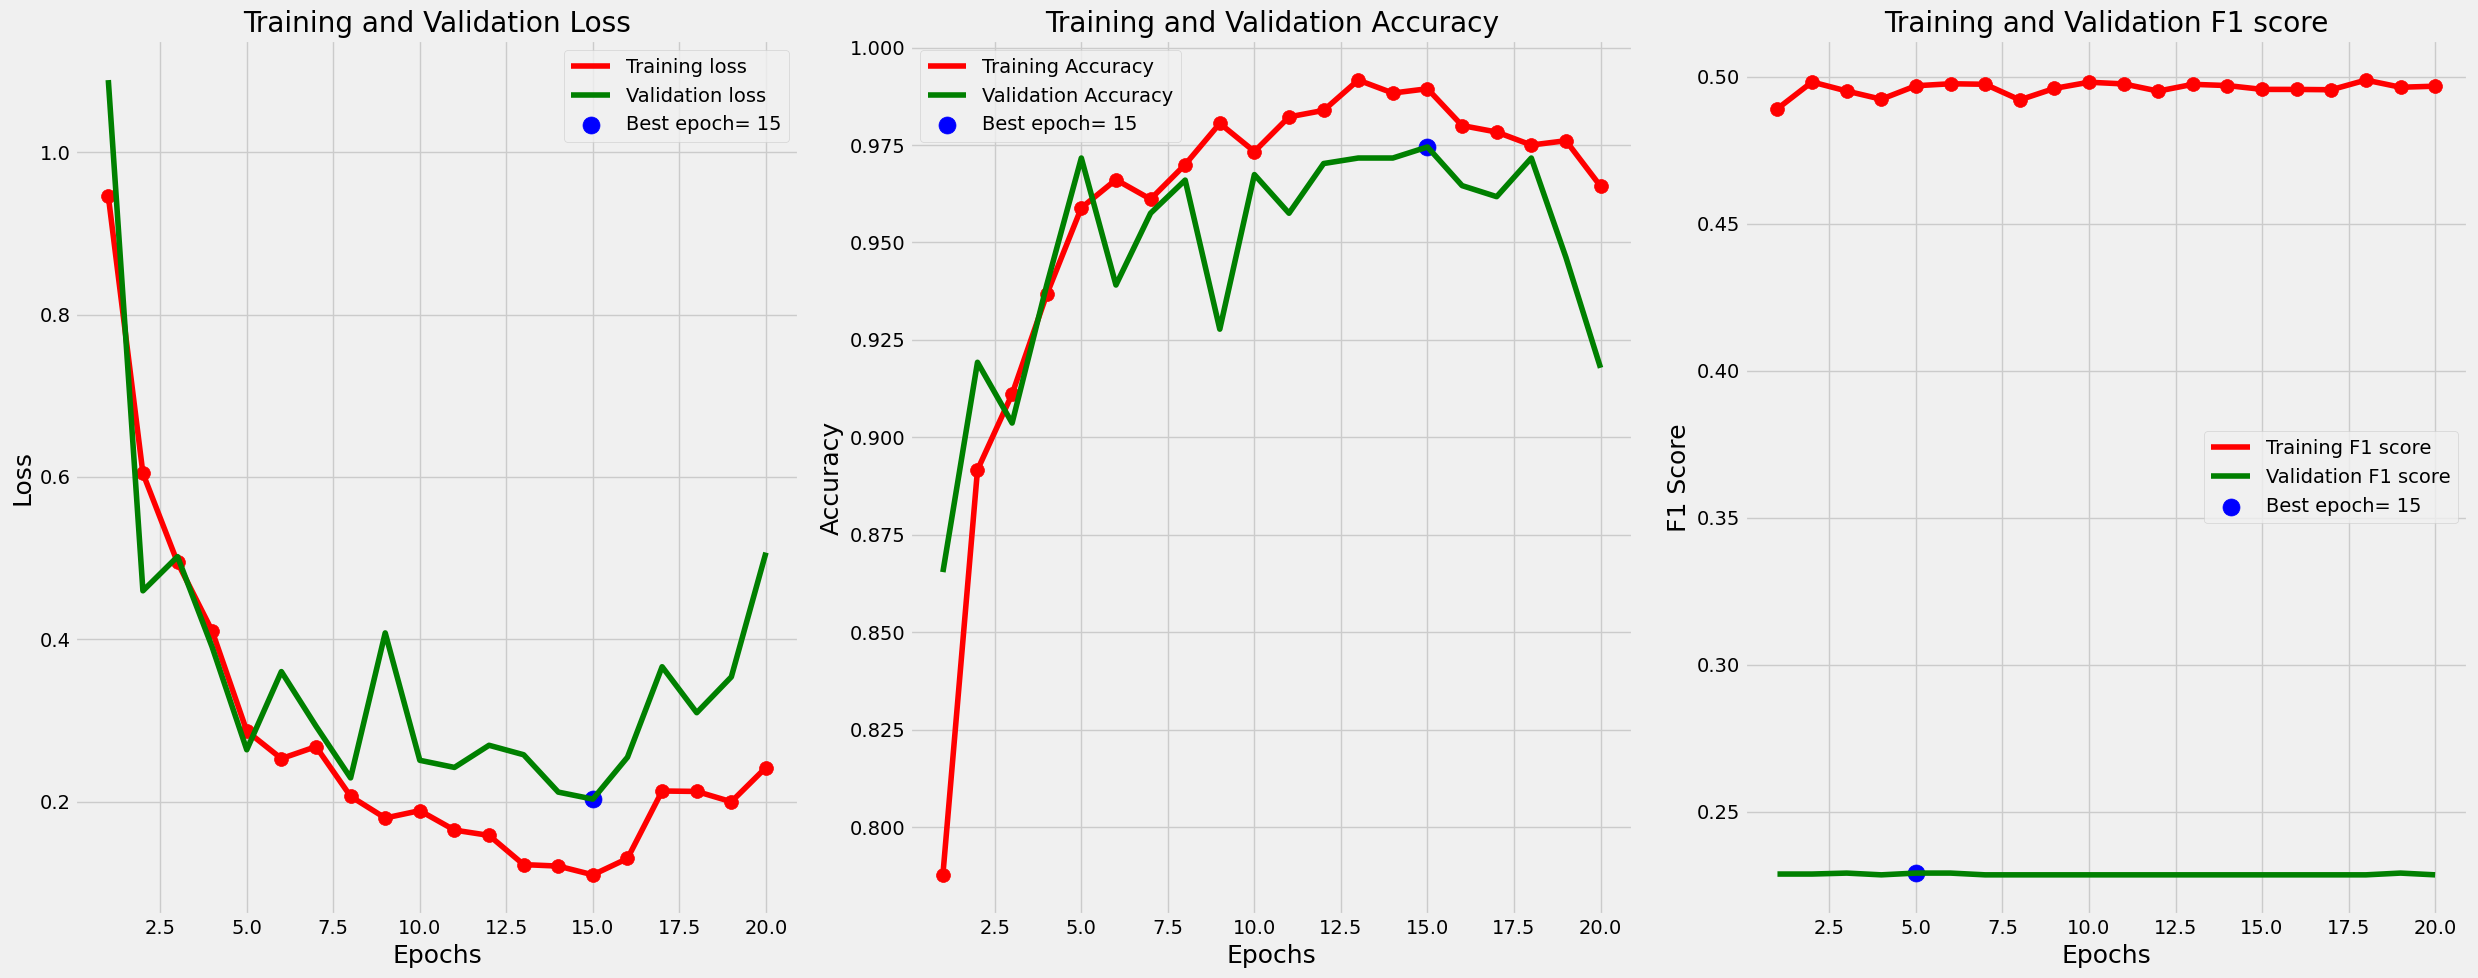

In [47]:
tr_plot(history)


In [10]:
def clear_model(model):
  model.reset_states()

In [11]:
clear_model(model)